In [0]:
import imageio
import cv2
import numpy as np
import os
import pickle
import re
import PIL
from PIL import Image

## Challenge Categories

In [0]:
CATEGORIES = [
    "boxing",
    "handclapping",
    "handwaving",
    "jogging",
    "running",
    "walking"
]

IMG_W = 60
IMG_H = 80
CHANNELS = 1
SEQ_LEN = 30
IMG_SHAPE = (IMG_W, IMG_H, CHANNELS)
INPUT_SHAPE = (SEQ_LEN, IMG_W, IMG_H, CHANNELS)
NCLASSES = 6

EPOCHS = 25

BATCH_SIZE = 64

### Spliting The Dataset

In [0]:
# Dataset are divided according to the instruction at:
# http://www.nada.kth.se/cvap/actions/00sequences.txt
TRAIN_PEOPLE_ID = [11, 12, 13, 14, 15, 16, 17, 18]
DEV_PEOPLE_ID = [19, 20, 21, 23, 24, 25, 1, 4]
TEST_PEOPLE_ID = [22, 2, 3, 5, 6, 7, 8, 9, 10]

## Loading The Dataset

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
print("Loading dataset ..")
train_videos = pickle.load(open("/content/drive/My Drive/DATASETS/KTH/Dataset pickles/train.p", "rb"))
dev_videos = pickle.load(open("/content/drive/My Drive/DATASETS/KTH/Dataset pickles/dev.p", "rb"))
test_videos = pickle.load(open("/content/drive/My Drive/DATASETS/KTH/Dataset pickles/test.p", "rb"))

Loading dataset ..


##Preparing The Dataset

In [0]:
def read_ds(ds="train", max_frames_per_video=0, separate_each_video=False):
  if(ds == "dev"):
    videos = dev_videos
  elif (ds == "test"):
    videos = test_videos
  else:
    videos = train_videos
      
  X = []
  y = []
  i=0
  X_per_video = []
  y_per_video = []
  print("total videos : %s" % len(videos))

  for video in videos: 

    if(max_frames_per_video == 0):

        for frame in video["frames"]:
            X.append(frame.reshape(IMG_SHAPE))
            y.append(CATEGORIES.index(video["category"]))
  
        if(separate_each_video):
            X_per_video.append(np.array(X, dtype=np.float32))
            y_per_video.append(np.array(y, dtype=np.uint8))
            X = []
            y = []  
        
    elif(max_frames_per_video == 1):

        index = np.random.choice(len(video["frames"]))
        frame_data = video["frames"][index]
  
        X.append(frame_data.reshape(IMG_SHAPE))
        y.append(CATEGORIES.index(video["category"]))

    else:

        skip = (len(video["frames"]) // max_frames_per_video)

        for i in range(0, len(video["frames"]), skip):
          X.append(np.array(video["frames"][i].reshape(IMG_SHAPE), dtype=np.float32))
        
        y.append(np.array(CATEGORIES.index(video["category"]), dtype=np.uint8))
        
        
        X = X[:max_frames_per_video]
        
        X_per_video.append(np.array(X, dtype=np.float32))
        y_per_video.append(np.array(y, dtype=np.uint8))

        X = []
        y = []  
      

  X = np.array(X, dtype=np.float32)
  y = np.array(y, dtype=np.uint8)


  if (max_frames_per_video == 0):
    if(separate_each_video):
      #for x in X_per_video:
        #mean = np.mean(x)
        #x -= float(mean)
      return np.array(X_per_video), np.array(y_per_video)
    
    #mean = np.mean(X)
    #X -= float(mean)
    
    return X, y

  elif (max_frames_per_video == 1):
    #mean = np.mean(X)
    #X -= float(mean)

    return X, y
  

  else: # (max_frames_per_video > 1):
    #for x in X_per_video:
      #mean = np.mean(x)
      #x -= float(mean)
      
    return np.array(X_per_video), np.array(y_per_video)

In [0]:
def generate_sequences(ds="train", separate_each_video=False):
  if(ds == "dev"):
    videos = dev_videos
  elif (ds == "test"):
    videos = test_videos
  else:
    videos = train_videos
      
  X = []
  y = []
  X_per_video = []
  y_per_video = []
  
  for video in videos:

    frames = video["frames"]
    sequences = len(frames) // SEQ_LEN
    seq_frames = []
    sequnces_frames = [] 
    step = SEQ_LEN
    for i in range(0, len(frames)):
      if(i < step):
        seq_frames.append(frames[i])
      else:
        sequnces_frames.append(seq_frames)
        seq_frames = []
        step = step + SEQ_LEN + 1
    sequnces_frames = np.array(sequnces_frames[:sequences])
    for seq in sequnces_frames:
      X.append(seq.reshape(INPUT_SHAPE))
      y.append(CATEGORIES.index(video["category"]))

    if(separate_each_video):
      if(len(X_per_video) == 0) :
        X_per_video.append(np.array(X))      
        y_per_video.append(np.array(y))      
      else: 
        X_per_video.append(np.array(X))
        y_per_video.append(np.array(y))
        #y_per_video = cat((y_per_video, np.array(y)), axis=0)

      X = []
      y = []  


  X = np.array(X, dtype=np.float32)
  y = np.array(y, dtype=np.uint8)

  if(separate_each_video):
    return np.array(X_per_video), np.array(y_per_video)

  return X, y

In [0]:
X_test_average_prediction, y_test_average_prediction = generate_sequences( ds="test", separate_each_video=True)
X_test_average_prediction.shape, y_test_average_prediction.shape

((216,), (216,))

In [0]:
X_test_average_prediction[0].shape, y_test_average_prediction[0].shape 

((13, 30, 60, 80, 1), (13,))

In [0]:
# X_train, y_train = read_ds(ds="train", max_frames_per_video=SEQ_LEN)
# X_dev, y_dev = read_ds(ds="dev", max_frames_per_video=SEQ_LEN)
# X_test, y_test = read_ds(ds="test", max_frames_per_video=SEQ_LEN)


X_train, y_train = generate_sequences(ds="train")
X_dev, y_dev = generate_sequences(ds="dev")
X_test, y_test = generate_sequences(ds="test")

In [0]:
X_test_average_prediction.shape, y_test_average_prediction.shape

((216,), (216,))

In [0]:
X_train.shape, y_train.shape 

((2316, 30, 60, 80, 1), (2316,))

In [0]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten
from keras.layers import InputLayer, Input, LSTM, TimeDistributed, ZeroPadding3D, Conv3D, MaxPooling3D, Activation, add
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import plot_model

In [0]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_dev = to_categorical(y_dev)
y_test = to_categorical(y_test)

##Preparing The Model (3D CNN - VGG16 Style)

In [0]:
# 3D CNN model (VGG Style)

# CNN model (VGG-like)
model = Sequential()
weights_init = 'glorot_uniform'

## Stage 1
model.add(ZeroPadding3D((3,3,3), input_shape=INPUT_SHAPE))
model.add(Conv3D(32,(3,3,3),kernel_initializer=weights_init))
model.add(BatchNormalization())
model.add(Conv3D(32,(3,3,3),activation='relu',padding='valid'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2),padding='valid'))

## Stage 2
model.add(Conv3D(64,(3,3,3),activation='relu',padding='valid'))
model.add(BatchNormalization())
model.add(Conv3D(64,(3,3,3),activation='relu',padding='valid'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2),padding='valid'))

## Stage 3
model.add(Conv3D(128,(3,3,3),activation='relu',padding='valid'))
model.add(BatchNormalization())
model.add(Conv3D(128,(3,3,3),activation='relu',padding='valid'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2),padding='valid'))

## Output
model.add(TimeDistributed(Flatten()))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(256,activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(512,activation='relu')))
model.add(Dropout(0.5))
model.add(LSTM(1024, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(NCLASSES,activation='softmax'))

In [0]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding3d_3 (ZeroPaddin (None, 36, 66, 86, 1)     0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 34, 64, 84, 32)    896       
_________________________________________________________________
batch_normalization_15 (Batc (None, 34, 64, 84, 32)    128       
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 32, 62, 82, 32)    27680     
_________________________________________________________________
batch_normalization_16 (Batc (None, 32, 62, 82, 32)    128       
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 16, 31, 41, 32)    0         
_________________________________________________________________
conv3d_15 (Conv3D)           (None, 14, 29, 39, 64)   

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

##Training The Model

In [0]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=5)
]

In [0]:
trained_model = model.fit(X_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_data=(X_dev, y_dev), callbacks=callbacks_list)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 2316 samples, validate on 2256 samples
Epoch 1/25





2316/2316 [==============================] - 61s 26ms/step - loss: 1.3839 - acc: 0.3765 - val_loss: 1.5982 - val_acc: 0.3613
Epoch 2/25
2316/2316 [==============================] - 41s 18ms/step - loss: 1.0021 - acc: 0.5242 - val_loss: 5.4081 - val_acc: 0.1941
Epoch 3/25
2316/2316 [==============================] - 41s 18ms/step - loss: 0.8119 - acc: 0.6282 - val_loss: 5.4829 - val_acc: 0.1946
Epoch 4/25
2316/2316 [==============================] - 41s 18ms/step - loss: 0.5494 - acc: 0.7673 - val_loss: 1.3065 - val_acc: 0.5762
Epoch 5/25
2316/2316 [==============================] - 41s 18ms/step - loss: 0.4151 - acc: 0.8351 - val_loss: 1.5570 - val_acc: 0.5745
Epoch 6/25
2316/2316 [==============================] - 41s 18ms/step - loss: 0.3608 - acc: 0.8558 - val_loss: 1.9733 - val_acc: 0.6037
Epoch 7/25
2316/2316 [============

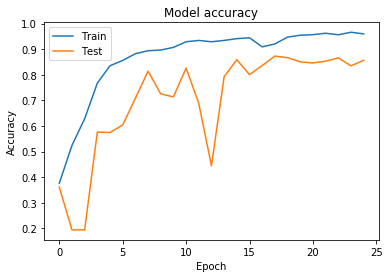

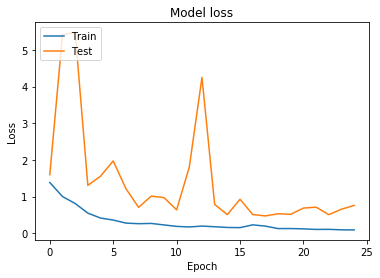

In [0]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(trained_model.history['acc'])
plt.plot(trained_model.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy') 
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

##Evaluating The Model
### 1) Simple Evaluation 


In [0]:
model.evaluate(X_test, y_test)

2450/2450 [==============================] - 12s 5ms/step


[0.8284964290681314, 0.8281632653061225]

### 2) Average Prediction Evaluation

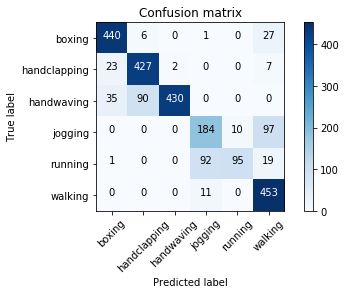

In [0]:
# Confusion matrix 
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = CATEGORIES) 

In [0]:
preds = np.array([])
pred_y = []
i = 0
for video_seq_frames in X_test_average_prediction:
  
  y_per_vid = np.array([])

  if(len(video_seq_frames.shape) == len(INPUT_SHAPE)): # if the video contains only 1 sequence
    #y_per_vid = cat((y_per_vid, y_test_average_prediction[i]), axis=0)
    p = model.predict(np.expand_dims(video_seq_frames, axis=0))
    
  else:
    #y_per_vid = cat((y_per_vid, y_test_average_prediction[i]), axis=0)
    p = model.predict(video_seq_frames)

  results = np.array(p).mean(axis=0)
  index = np.argmax(results)
  label = CATEGORIES[index]
  pred_y.append(index)

  #preds = cat((preds, p))
  preds = np.append(preds, p)

  i+=1

pred_y = np.array(pred_y, dtype=np.str)

In [0]:
y_test_per_video_classes = []
_, y_test_per_video = read_ds(ds="test", max_frames_per_video=1)
y_test_per_video = to_categorical(y_test_per_video)

for y in y_test_per_video:
  index = np.argmax(y)
  label = CATEGORIES[index]
  y_test_per_video_classes.append(index)
y_test_per_video_classes = np.array(y_test_per_video_classes, dtype=np.str)

total videos : 216


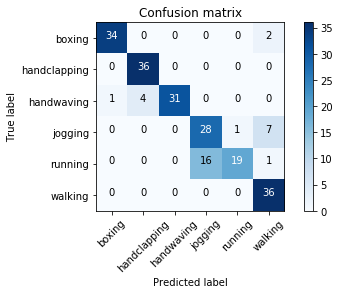

In [0]:
confusion_mtx = confusion_matrix(y_test_per_video_classes, pred_y) 
plot_confusion_matrix(confusion_mtx, classes = CATEGORIES) 

In [0]:
i=0
acc=0
for y in pred_y:
  if(y == y_test_per_video_classes[i]):
    acc+=1
  i+=1

accuracy = acc / len(pred_y)
print("Average Prediction Accuracy : %s" % accuracy)

Average Prediction Accuracy : 0.8518518518518519


### 3) Max Prediction Evaluation

In [0]:
preds = np.array([])
pred_y = []
i = 0
for video_seq_frames in X_test_average_prediction:
  
  y_per_vid = np.array([])

  if(len(video_seq_frames.shape) == len(INPUT_SHAPE)): # if the video contains only 1 sequence
    #y_per_vid = cat((y_per_vid, y_test_average_prediction[i]), axis=0)
    p = model.predict(np.expand_dims(video_seq_frames, axis=0))
    
  else:
    #y_per_vid = cat((y_per_vid, y_test_average_prediction[i]), axis=0)
    p = model.predict(video_seq_frames)

  results = np.array(p).max(axis=0)
  index = np.argmax(results)
  label = CATEGORIES[index]
  pred_y.append(index)

  #preds = cat((preds, p))
  preds = np.append(preds, p)

  i+=1

pred_y = np.array(pred_y, dtype=np.str)

In [0]:
y_test_per_video_classes = []
_, y_test_per_video = read_ds(ds="test", max_frames_per_video=1)
y_test_per_video = to_categorical(y_test_per_video)

for y in y_test_per_video:
  index = np.argmax(y)
  label = CATEGORIES[index]
  y_test_per_video_classes.append(index)
y_test_per_video_classes = np.array(y_test_per_video_classes, dtype=np.str)

total videos : 216


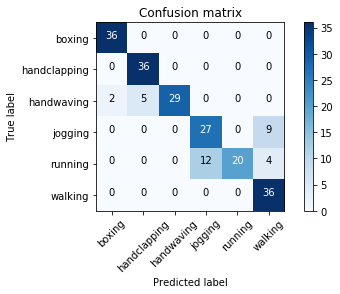

In [0]:
confusion_mtx = confusion_matrix(y_test_per_video_classes, pred_y) 
plot_confusion_matrix(confusion_mtx, classes = CATEGORIES) 

In [0]:
i=0
acc=0
for y in pred_y:
  if(y == y_test_per_video_classes[i]):
    acc+=1
  i+=1

accuracy = acc / len(pred_y)
print("Max Prediction Accuracy : %s" % accuracy)

Max Prediction Accuracy : 0.8518518518518519


##Saving The Model 

In [0]:
model.save_weights('3DCNN_KTH.h5')

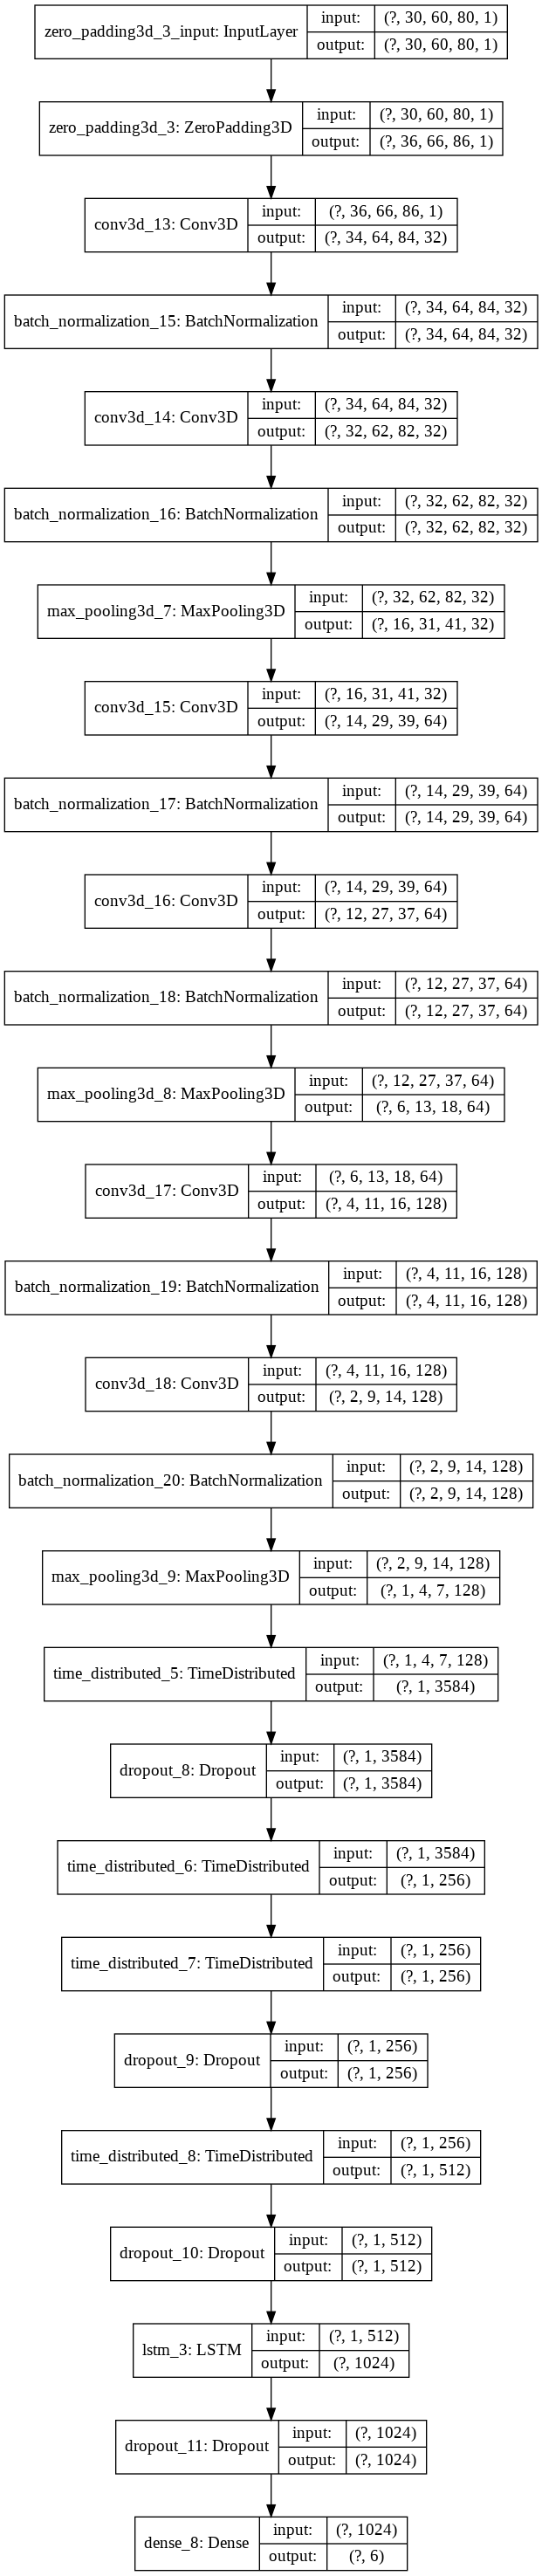

In [0]:
plot_model(model, show_shapes=True, to_file='3DCNN_KTH.png')